```markdown
# 全连接神经网络
在本练习中，我们将采用模块化方法实现全连接网络。  
对于每一层，我们将分别实现 `forward`（前向传播）和 `backward`（反向传播）函数。  
`forward` 函数将接收输入、权重等参数，并返回输出以及一个 `cache` 对象，`cache` 用于存储反向传播时需要的数据，例如：

```python
def layer_forward(x, w):
    """接收输入 x 和权重 w"""
    # 进行一些计算 ...
    z = # ... 一个中间值
    # 继续进行一些计算 ...
    out = # 最终输出

    cache = (x, w, z, out)  # 用于计算梯度的值

    return out, cache
```

`backward` 函数将接收上游梯度和 `cache` 对象，并返回相对于输入和权重的梯度，例如：

```python
def layer_backward(dout, cache):
    """
    接收 dout（相对于输出的损失梯度）和 cache，
    并计算相对于输入的梯度。
    """
    # 解包 cache 中的值
    x, w, z, out = cache

    # 使用 cache 中的值计算梯度
    dx = # 相对于 x 的损失梯度
    dw = # 相对于 w 的损失梯度

    return dx, dw
```

按照这种方式实现多层后，我们将能够轻松组合它们，构建不同架构的分类器。
```
  

In [15]:
# 常规初始化设置
from __future__ import print_function  # 确保兼容 Python 2 和 3 的打印函数
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *  # 全连接网络
from cs231n.data_utils import get_CIFAR10_data  # CIFAR-10 数据加载工具
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver  # 通用训练器

# 让 matplotlib 图形直接嵌入在 notebook 中，而不是弹出新窗口
%matplotlib inline
# 统一设置图片默认大小，便于查看
plt.rcParams['figure.figsize'] = (10.0, 8.0)
# 关闭插值，使像素边界更清晰
plt.rcParams['image.interpolation'] = 'nearest'
# 灰度图默认使用灰度色图
plt.rcParams['image.cmap'] = 'gray'

# 开启 IPython 的自动重载功能：修改外部 .py 文件后无需重启 kernel 即可生效
# 官方讨论贴地址：http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 注意：由于网络原因，上述链接暂时无法成功解析。如果你需要查看该网页内容，
# 请检查链接是否有效，或稍后重试；若不需要查看，可直接继续后续操作。
%load_ext autoreload
%autoreload 2

# 定义相对误差计算函数，用于验证梯度
def rel_error(x, y):
    """返回相对误差"""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# 加载已经预处理过的 CIFAR-10 数据
data = get_CIFAR10_data()

# 打印各数据集的名称和形状
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# 仿射层：前向传播
打开文件 `cs231n/layers.py` 并实现 `affine_forward` 函数。

完成后，运行以下代码测试你的实现：

In [17]:
# 测试 affine_forward 函数

# 设置测试参数
num_inputs = 2           # 输入样本数
input_shape = (4, 5, 6)  # 每个输入样本的形状
output_dim = 3           # 输出维度

# 计算输入和权重的总大小
input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

# 构造测试输入、权重和偏置
x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

# 调用 affine_forward 函数
out, _ = affine_forward(x, w, b)

# 官方提供的正确输出
correct_out = np.array([[1.49834967,  1.70660132,  1.91485297],
                        [3.25553199,  3.5141327,   3.77273342]])

# 比较你的输出与官方正确输出。误差应接近 e-9 或更小。
print('测试 affine_forward 函数:')
print('差异: ', rel_error(out, correct_out))

测试 affine_forward 函数:
差异:  9.769847728806635e-10


# 仿射层：反向传播
现在实现 `affine_backward` 函数，并使用数值梯度检查测试你的实现。

In [18]:
# 测试 affine_backward 函数
np.random.seed(231)  # 设置随机种子确保结果可复现

# 构造随机输入、权重、偏置和输出梯度
x = np.random.randn(10, 2, 3)  # 输入数据
w = np.random.randn(6, 5)      # 权重
b = np.random.randn(5)         # 偏置
dout = np.random.randn(10, 5)  # 上游梯度

# 使用数值梯度计算函数计算 dx、dw、db 的数值梯度
dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

# 调用 affine_backward 函数计算解析梯度
_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# 比较数值梯度和解析梯度，误差应接近 e-10 或更小
print('测试 affine_backward 函数:')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 affine_backward 函数:
dx 误差:  5.399100368651805e-11
dw 误差:  9.904211865398145e-11
db 误差:  2.4122867568119087e-11


# ReLU 激活函数：前向传播
在 `relu_forward` 函数中实现 ReLU 激活函数的前向传播，并使用以下代码测试你的实现：

In [19]:
# 测试 relu_forward 函数

# 构造测试输入
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

# 调用 ReLU 前向传播函数
out, _ = relu_forward(x)

# 官方提供的正确输出
correct_out = np.array([[0.,          0.,          0.,          0.,        ],
                        [0.,          0.,          0.04545455,  0.13636364,],
                        [0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# 比较你的输出与官方正确输出。误差应在 e-8 数量级。
print('测试 relu_forward 函数:')
print('差异: ', rel_error(out, correct_out))

测试 relu_forward 函数:
差异:  4.999999798022158e-08


# ReLU 激活函数：反向传播
现在在 `relu_backward` 函数中实现 ReLU 激活函数的反向传播，并使用数值梯度检查测试你的实现：

In [20]:
# 测试 ReLU 反向传播函数
np.random.seed(231)  # 设置随机种子确保结果可复现

# 构造随机输入和输出梯度
x = np.random.randn(10, 10)  # 输入数据
dout = np.random.randn(*x.shape)  # 上游梯度

# 使用数值梯度计算函数计算 dx 的数值梯度
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

# 调用 ReLU 反向传播函数计算解析梯度
_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# 比较数值梯度和解析梯度，误差应在 e-12 数量级
print('测试 relu_backward 函数:')
print('dx 误差: ', rel_error(dx_num, dx))

测试 relu_backward 函数:
dx 误差:  3.2756349136310288e-12


**内联问题 1：**

我们只让你实现了 ReLU，但神经网络中可以使用许多不同的激活函数，每个激活函数都有其优缺点。  
特别地，激活函数常见的一个问题是在反向传播中梯度消失（或接近消失）。  
以下哪些激活函数存在这个问题？  
如果你考虑这些函数在一维情况下的表现，哪些类型的输入会导致这种行为？  
1. Sigmoid  
2. ReLU  
3. Leaky ReLU  

$\color{blue}{\textit{你的答案：}}$ *sigmoid，因为当x过大或过小时梯度会趋于零，relu再x小于零时也会梯度趋于零*




# “三明治”层
神经网络中有一些常见的层组合模式。例如，仿射层通常后面会接一个 ReLU 非线性激活函数。  
为了方便使用这些常见模式，我们在文件 `cs231n/layer_utils.py` 中定义了一些便捷函数。

目前先查看 `affine_relu_forward` 和 `affine_relu_backward` 函数，并运行以下代码进行数值梯度检查：

In [21]:
# 测试 affine_relu_forward 和 affine_relu_backward 函数
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward

# 设置随机种子确保结果可复现
np.random.seed(231)

# 构造随机输入、权重、偏置和输出梯度
x = np.random.randn(2, 3, 4)  # 输入数据
w = np.random.randn(12, 10)   # 权重
b = np.random.randn(10)       # 偏置
dout = np.random.randn(2, 10) # 上游梯度

# 调用 affine_relu_forward 函数
out, cache = affine_relu_forward(x, w, b)

# 调用 affine_relu_backward 函数计算解析梯度
dx, dw, db = affine_relu_backward(dout, cache)

# 使用数值梯度计算函数计算 dx、dw、db 的数值梯度
dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# 比较数值梯度和解析梯度，相对误差应接近 e-10 或更小
print('测试 affine_relu_forward 和 affine_relu_backward:')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 affine_relu_forward 和 affine_relu_backward:
dx 误差:  6.750562121603446e-11
dw 误差:  8.162015570444288e-11
db 误差:  7.826724021458994e-12


# 损失层：Softmax
现在在 `cs231n/layers.py` 中的 `softmax_loss` 函数里实现 Softmax 损失及其梯度。  
这些实现应与你在 `cs231n/classifiers/softmax.py` 中完成的类似。  
其他损失函数（例如 `svm_loss`）也可以以模块化方式实现，但这不是本次作业的要求。

你可以通过运行以下代码来验证实现是否正确：

In [22]:
# 测试 softmax_loss 函数
np.random.seed(231)  # 设置随机种子确保结果可复现

# 构造随机输入和标签
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)  # 输入数据
y = np.random.randint(num_classes, size=num_inputs)   # 随机标签

# 使用数值梯度计算函数计算 dx 的数值梯度
dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)

# 调用 softmax_loss 函数计算损失和解析梯度
loss, dx = softmax_loss(x, y)

# 验证 softmax_loss 函数。损失值应接近 2.3，dx 误差应在 e-8 数量级
print('\n测试 softmax_loss:')
print('损失: ', loss)
print('dx 误差: ', rel_error(dx_num, dx))


测试 softmax_loss:
损失:  2.3025458445007376
dx 误差:  8.234144091578429e-09


# 两层网络
打开文件 `cs231n/classifiers/fc_net.py` 并完成 `TwoLayerNet` 类的实现。  
仔细阅读代码以确保你理解其 API。  
你可以运行以下代码单元来测试你的实现。

In [23]:
# 设置随机种子，确保结果可复现
np.random.seed(231)

# 构造一个小规模数据集用于快速测试
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

# 初始化 TwoLayerNet，权重初始标准差设为 1e-3
std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

# 测试权重和偏置的初始化是否正确
print('测试初始化...')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, '第一层权重初始化似乎不正确'
assert np.all(b1 == 0), '第一层偏置初始化似乎不正确'
assert W2_std < std / 10, '第二层权重初始化似乎不正确'
assert np.all(b2 == 0), '第二层偏置初始化似乎不正确'

# 测试推理阶段的前向传播
print('测试推理阶段的前向传播...')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

# 官方提供的正确输出
correct_scores = np.asarray([
  [11.53165108, 12.2917344,  13.05181771, 13.81190102, 14.57198434, 15.33206765, 16.09215096],
  [12.05769098, 12.74614105, 13.43459113, 14.1230412,  14.81149128, 15.49994135, 16.18839143],
  [12.58373087, 13.20054771, 13.81736455, 14.43418138, 15.05099822, 15.66781506, 16.2846319 ]
])

# 比较误差
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, '推理阶段前向传播存在问题'

# 测试训练损失（无正则化）
print('测试训练损失（无正则化）...')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, '训练阶段损失存在问题'

# 测试正则化损失
model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, '正则化损失存在问题'

# 数值梯度检查（相对误差应在 e-7 或更低）
for reg in [0.0, 0.7]:
    print('使用 reg =', reg, '进行数值梯度检查')
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s 相对误差: %.2e' % (name, rel_error(grad_num, grads[name])))

测试初始化...
测试推理阶段的前向传播...
测试训练损失（无正则化）...
使用 reg = 0.0 进行数值梯度检查
W1 相对误差: 1.52e-08
W2 相对误差: 3.48e-10
b1 相对误差: 6.55e-09
b2 相对误差: 4.33e-10
使用 reg = 0.7 进行数值梯度检查
W1 相对误差: 8.18e-07
W2 相对误差: 2.85e-08
b1 相对误差: 1.09e-09
b2 相对误差: 9.09e-10


# Solver  
打开文件 `cs231n/solver.py` 并通读一遍，熟悉其接口。  
完成后，使用 `Solver` 实例训练一个 `TwoLayerNet`，使其在验证集上的准确率达到约 **36%**。

In [26]:
input_size = 32 * 32 * 3    # 每个样本的展平像素数
hidden_size = 50            # 隐藏层神经元数量
num_classes = 10            # 类别数（CIFAR-10）

# 创建两层全连接网络
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = Solver(model, data,
                num_epochs=5, batch_size=100,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=100)

##############################################################################
# 代办：使用 Solver 实例训练一个 TwoLayerNet，使其在验证集上的准确率达到约 36%。#
##############################################################################
solver.train()
val_acc = solver.check_accuracy(data['X_val'], data['y_val'])
print('验证集准确率: ', val_acc)
##############################################################################
#                             代码结束                                       #
##############################################################################

(Iteration 1 / 2450) loss: 2.304607
(Epoch 0 / 5) train acc: 0.108000; val_acc: 0.108000
(Iteration 101 / 2450) loss: 1.810246
(Iteration 201 / 2450) loss: 1.740551
(Iteration 301 / 2450) loss: 1.659631
(Iteration 401 / 2450) loss: 1.476447
(Epoch 1 / 5) train acc: 0.444000; val_acc: 0.470000
(Iteration 501 / 2450) loss: 1.741060
(Iteration 601 / 2450) loss: 1.565520
(Iteration 701 / 2450) loss: 1.569448
(Iteration 801 / 2450) loss: 1.488075
(Iteration 901 / 2450) loss: 1.470391
(Epoch 2 / 5) train acc: 0.506000; val_acc: 0.470000
(Iteration 1001 / 2450) loss: 1.774859
(Iteration 1101 / 2450) loss: 1.408559
(Iteration 1201 / 2450) loss: 1.435751
(Iteration 1301 / 2450) loss: 1.372105
(Iteration 1401 / 2450) loss: 1.322853
(Epoch 3 / 5) train acc: 0.465000; val_acc: 0.482000
(Iteration 1501 / 2450) loss: 1.452572
(Iteration 1601 / 2450) loss: 1.386079
(Iteration 1701 / 2450) loss: 1.576186
(Iteration 1801 / 2450) loss: 1.259600
(Iteration 1901 / 2450) loss: 1.669160
(Epoch 4 / 5) train 

# 调试训练过程
使用上面给出的默认超参数，你应在验证集上得到约 0.36 的准确率，这并不理想。

获取洞察的一种策略是：在优化过程中绘制损失函数曲线，以及训练集和验证集的准确率曲线。

另一种策略是：可视化网络第一层学习到的权重。在大多数基于视觉数据训练的神经网络中，第一层的权重在可视化后通常会呈现出明显的结构。

d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  

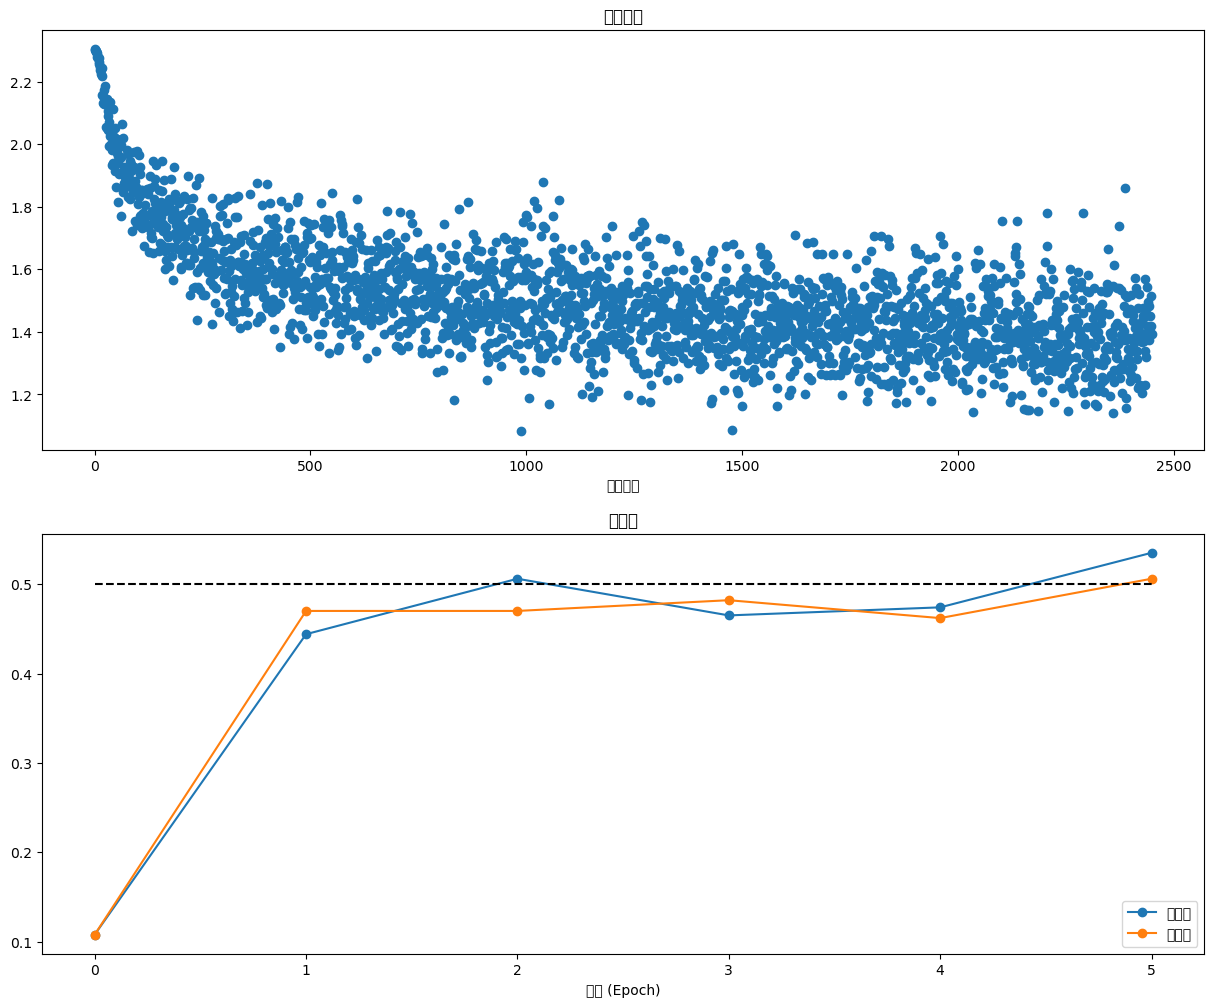

In [27]:
# 运行该单元格，可视化训练损失及训练/验证准确率

# 第一幅子图：训练损失
plt.subplot(2, 1, 1)
plt.title('训练损失')
plt.plot(solver.loss_history, 'o')
plt.xlabel('迭代次数')

# 第二幅子图：准确率
plt.subplot(2, 1, 2)
plt.title('准确率')
plt.plot(solver.train_acc_history, '-o', label='训练集')
plt.plot(solver.val_acc_history, '-o', label='验证集')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')  # 50% 基线
plt.xlabel('轮次 (Epoch)')
plt.legend(loc='lower right')

# 设置整体大小
plt.gcf().set_size_inches(15, 12)
plt.show()

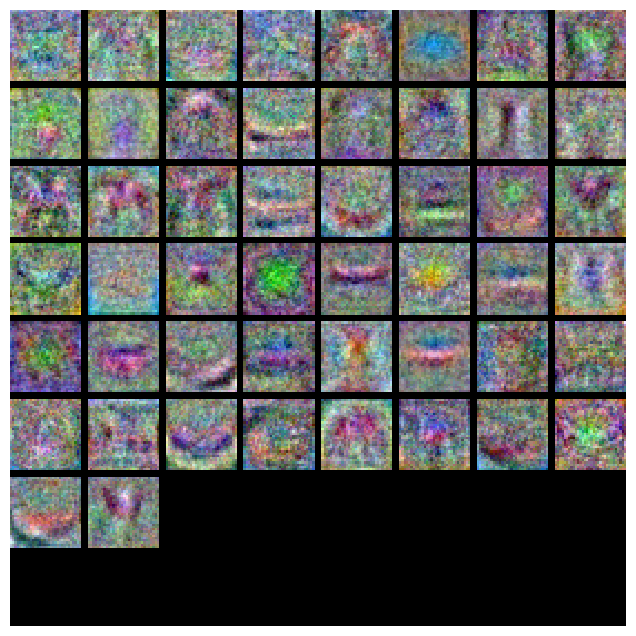

In [28]:
# 可视化网络权重
from cs231n.vis_utils import visualize_grid

def show_net_weights(net):
    # 取出第一层的权重 W1，并重塑为 (3, 32, 32, hidden_dim)
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)  # 调整为 (hidden_dim, 32, 32, 3)
    # 使用可视化工具将权重显示为网格图像
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')  # 关闭坐标轴
    plt.show()

# 显示当前训练模型的第一层权重
show_net_weights(model)

# 调整超参数

**问题出在哪？**  
从上面的可视化可以看出：
- 损失几乎呈线性下降，这表明学习率可能太低。  
- 训练准确率与验证准确率几乎没有差距，说明模型容量偏小，应增大网络规模。  
- 反之，如果模型过大，我们通常会看到明显的过拟合，即训练准确率远高于验证准确率。

**调参**  
调整超参数并培养“它们如何影响最终性能”的直觉，是使用神经网络的重要部分。  
下面，你应该尝试不同的超参数组合，包括：
- 隐藏层大小  
- 学习率  
- 训练轮数（epochs）  
- 正则化强度  

你也可以尝试调节学习率衰减，但使用默认值即可取得较好效果。

**预期结果**  
目标是在验证集上获得 **>48%** 的准确率。  
我们最好的网络在验证集上可达 **>52%**。

**实验任务**  
本次实验的目标是：  
用**全连接神经网络**在 CIFAR-10 上取得尽可能高的结果（52% 可作为参考）。  
你可以自由实现自己的想法（例如：用 PCA 降维、添加 Dropout、在 Solver 中加入额外特性等）。

In [29]:
best_model = solver.model

#################################################################################
# 代办：在验证集上通过调参找到最优超参数，并将训练好的最佳模型保存到 best_model。   #
#                                                                               #
# 为帮助调试网络，你可以使用与前面类似的权重可视化；当网络调优后，这些可视化结果     #
# 会在质上与之前表现不佳网络的可视化有明显区别。                                   #
#                                                                               #
# 手动调参虽然有趣，但编写代码自动遍历超参数组合（如之前练习所做）会更高效。         #
#################################################################################

################################################################################
#                              代码结束                                        #
################################################################################

# 测试你的模型！
用你训练出的最优模型在验证集和测试集上运行，  
你应当在验证集和测试集上都获得 **高于 48%** 的准确率。

In [30]:
# 在验证集上评估最优模型
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('验证集准确率: ', (y_val_pred == data['y_val']).mean())

验证集准确率:  0.506


In [31]:
# 在测试集上评估最优模型
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('测试集准确率: ', (y_test_pred == data['y_test']).mean())

测试集准确率:  0.48


In [32]:
# 保存最优模型
best_model.save("best_two_layer_net.npy")

best_two_layer_net.npy 已保存。


**内联问题 2：**

现在你已经训练了一个神经网络分类器，可能会发现测试准确率远低于训练准确率。我们可以用哪些方法来缩小这一差距？请选择所有适用的选项。

1. 在更大的数据集上训练。  
2. 增加隐藏单元数量。  
3. 增大正则化强度。  
4. 以上都不是。

$\color{blue}{\textit{你的答案：}}$

$\color{blue}{\textit{你的解释：}}$



In [ ]:
13
